In [13]:
import os
from os.path import expanduser
import socket
import sys
import glob

# BELOW IS SYSTEM/PATH CONFIGURATION #
my_home = expanduser("~")
running_system = socket.gethostname()
# Configure machine's names here #
systemHLRN = 'blogin1'
systemLOCAL = 'Laurents-MacBook-Pro.local'
my_home = expanduser("~")
# Define local pass #
wd_path = '/home/hbkoziel/pyfesom/'

#sys.path.append("codes/modules") # add custom Vibe 's modules
sys.path.append('../..') # add standard 's modules
sys.path.append('../modules')
#########################################

In [14]:
import pyfesom as pf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import numpy as np
from netCDF4 import Dataset
import time
from scipy.interpolate import griddata
import xarray as xr
import pandas as pd

sys.path.append('/home/hbkoziel/pyfesom/pyfesom/cmocean/')
import cmocean as cmap

In [15]:
# Loading mesh for run

mesh_id    = 'meshArc4.5'
meshpath   = '/scratch/usr/hbkoziel/mesh/'+mesh_id+'/'             # Defining path where mesh is stored
mesh = pf.load_mesh(meshpath, usepickle=True, get3d=True)                                    # Loading mesh, stores it in mesh.****  
#mesh = pf.fesom_mesh(meshpath, get3d=True)
mesh.zlevs = -mesh.zlevs                                            # Depth is made negative

tracername = 'tr01'
first_year = 1985
last_year  = 2015
years      = np.arange(first_year,last_year+1,1)
runid	= 'Arc12'

data_path  = '/scratch/usr/hbkoziel/'+runid+'/netcdf/'

/scratch/usr/hbkoziel/mesh/meshArc4.5/pickle_mesh
2
The usepickle == True)
The pickle file for python 2 exists.
The mesh will be loaded from /scratch/usr/hbkoziel/mesh/meshArc4.5/pickle_mesh


In [16]:
dates = pd.date_range('1985', freq="M", periods= 12*len(np.arange(1985,2016,1)))
data = xr.open_mfdataset(data_path+tracername+'*.nc', concat_dim='time')
data['time'] = dates
#data.time.data = dates

In [17]:
data

<xarray.Dataset>
Dimensions:  (nod2d: 753179, nod3d: 16950142, time: 372)
Coordinates:
  * time     (time) datetime64[ns] 1985-01-31 1985-02-28 ... 2015-12-31
Dimensions without coordinates: nod2d, nod3d
Data variables:
    tr01     (time, nod3d) float64 dask.array<shape=(372, 16950142), chunksize=(12, 16950142)>
    tr0150m  (time, nod2d) float64 dask.array<shape=(372, 753179), chunksize=(12, 753179)>
Attributes:
    description:  REcoM tracer 01
    history:      Created Wed Dec  9 14:42:16 2020

In [18]:
din_sel = data.tr01.sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
din_sel = din_sel.compute()

In [19]:
din_mean = din_sel.mean(dim='time')
din_mean = din_mean.compute()

In [20]:
data2_d0, elem_no_nan = pf.get_data(din_mean,mesh,0)
data2_d1000, elem_no_nan = pf.get_data(din_mean,mesh,-1000)
data2_d2000, elem_no_nan = pf.get_data(din_mean,mesh,-2000)

For depth 0 model level 0.0 will be used
For depth -1000 model level -1040.0 will be used
For depth -2000 model level -1920.0 will be used


In [21]:
# WOA data
f          = Dataset('/scratch/usr/hbkoziel/input/woa13_all_n00_01.nc', 'r')
DepthRaw   = -f.variables['depth'][:]                                # Depth is negative
lonwoa     =  f.variables['lon'][:]
latwoa     =  f.variables['lat'][:]
DSiwoa     =  f.variables['n_an'][:]
DSiwoa     = np.squeeze(DSiwoa)
DSiwoa     = np.ma.filled(DSiwoa, np.nan)                            # From masked array to numpy array
        
X360, Y180 = np.meshgrid(lonwoa, latwoa)
        
dsi_int = np.zeros(len(mesh.z3))                                  # initializing target field for interpolation 
for k in range(0,len(mesh.zlevs)):                                # Looping through all depth levels in fesom's grid to interpolate vertically
    lev  = mesh.zlevs[k]                                            # Current fesom depth
    ind1 = np.where(DepthRaw >= lev)[0]                             # find the level in data at the same depth or depth above
    ind1 = ind1[-1]
    ind2 = np.where(DepthRaw < lev)[0]                              # find the level in data at the depth below current fesom depth level
    if ind2.size > 0:                                               # If we have not yet reached the bottom
        ind2 = ind2[0]                                                # The index of the depth level below the current fesom level
        c    = DepthRaw[ind1]-DepthRaw[ind2]                          # Difference in depth between the data value above and below the fesom depth
        c1   = DepthRaw[ind1]-lev                                     # Difference between fesom depth and data depth above
        c2   = -(DepthRaw[ind2]-lev)                                  # Difference between fesom depth and data depth below
        c1   = (c-c1)/c                                               # Scaling coefficient for the depth above
        c2   = (c-c2)/c                                               # Scaling coefficient for the depth below
    else:                                                           # We have reached the bottom
        c1   = 1.
        c2   = 0.
        ind2 = ind1
  
    indZ  = np.where(-mesh.z3 == lev)                               # Find the mesh index of the current fesom depth
    aux1  = DSiwoa[ind1,:,:]                                        # Find the data above the current fesom depth
    aux2  = DSiwoa[ind2,:,:]                                        # Find the data below the current fesom depth
    aux   = c1*aux1+c2*aux2                                         # Scaling the data according to vertical distribution as found above

    ind   = ~np.isnan(aux)                                          # The index of aux that are not NaNs

    aux           = griddata((X360[ind], Y180[ind]), aux[ind], (X360, Y180), method='nearest')                             # 2D field without nans                           
    dsi_int[indZ] = griddata((X360.ravel(), Y180.ravel()), aux.ravel(), (mesh.x3[indZ], mesh.y3[indZ]), method='nearest')  # Final interpolated field

    if np.isnan(np.min(dsi_int[indZ])): print 'WARNING: The interpolated field contains NaNs at depth',lev                # Testing if results contain NaNs. If yes, the routine needs adjustments
        
print np.shape(dsi_int)
        
level_data, elem_no_nan = pf.get_data(dsi_int,mesh,0)
data1_d0 = level_data#dsi_int[0:len(mesh.x2)]

level_data, elem_no_nan = pf.get_data(dsi_int,mesh,-1000)
data1_d1000 = level_data#dsi_int[0:len(mesh.x2)]

level_data, elem_no_nan = pf.get_data(dsi_int,mesh,-2000)
data1_d2000 = level_data#dsi_int[0:len(mesh.x2)]

(16950142,)
For depth 0 model level 0.0 will be used
For depth -1000 model level -1040.0 will be used
For depth -2000 model level -1920.0 will be used


In [22]:
from PiecewiseNorm import PiecewiseNorm
#import skill_metrics as sm

ftriplot, number of dummy points: 0
ftriplot, number of dummy points: 0
ftriplot, number of dummy points: 0
ftriplot, number of dummy points: 768314
ftriplot, number of dummy points: 768314
ftriplot, number of dummy points: 768314
ftriplot, number of dummy points: 894189
ftriplot, number of dummy points: 894189
ftriplot, number of dummy points: 894189


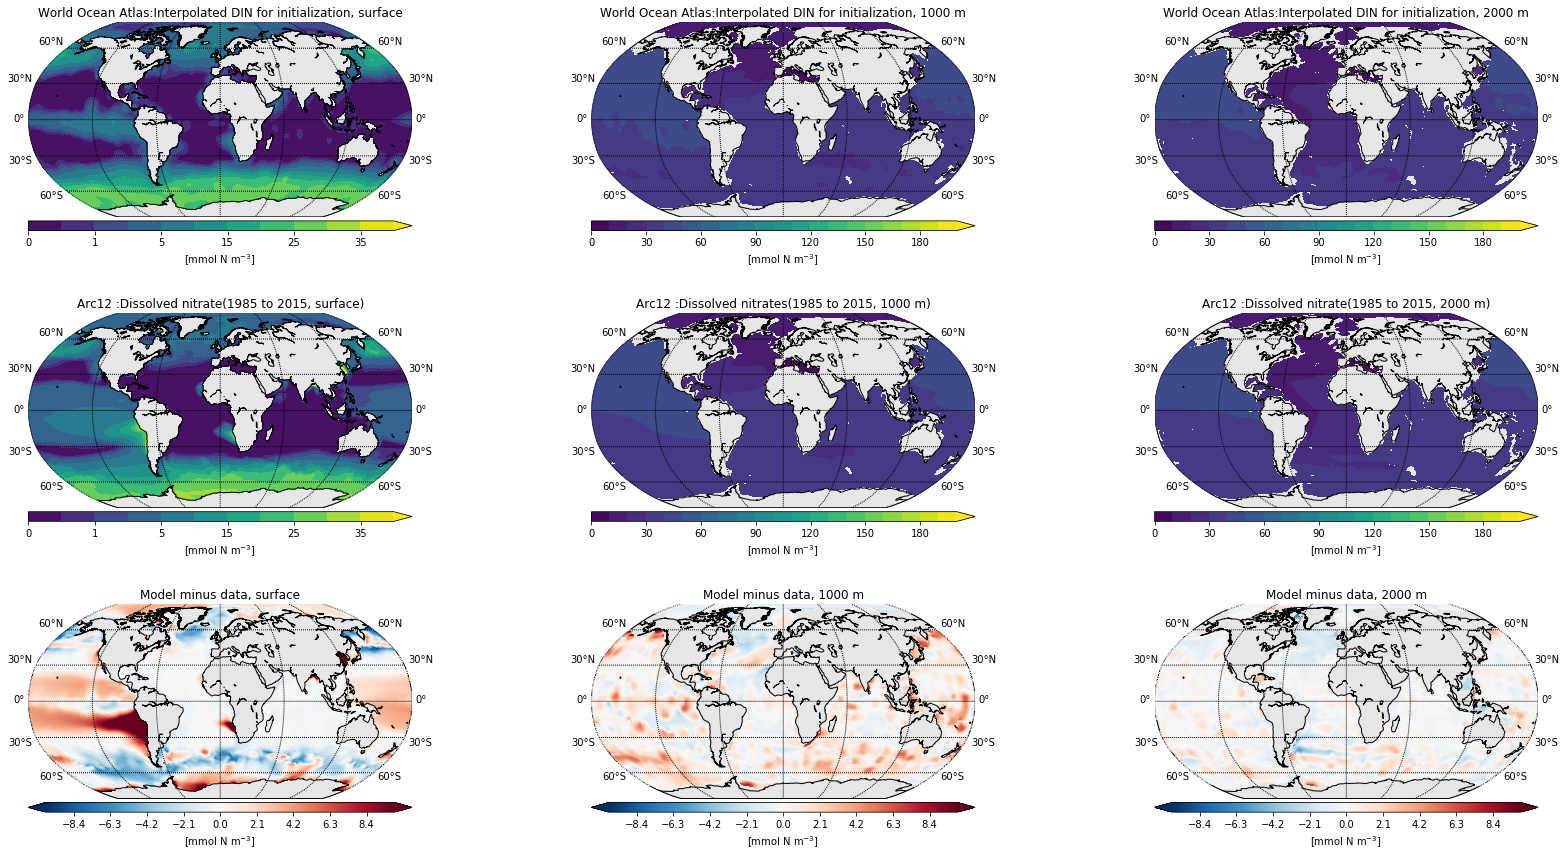

In [25]:
        viridis = cm.viridis
        diff_d0 =data2_d0-data1_d0
        diff_d1000 =data2_d1000-data1_d1000
        diff_d2000 =data2_d2000-data1_d2000
            
        dpicnt = 600
        if dpicnt == 600:
            xlablesize   = 12
            ylabelsize   = 12
            titlesize    = 14
            shrinkfactor = 0.9
        elif dpicnt == 200:
            xlablesize   = 8
            ylabelsize   = 8
            titlesize    = 10
            shrinkfactor = 0.9

        contours=np.array([0.,0.5,1.,2.,5.,10.,15,20.,25,30.,35,40.])
        # for difference plot
        contours1 = [-10, 10, 0.1]
        contours1 = np.arange(contours1[0], contours1[1]+contours1[2], contours1[2])

        unit = '[mmol N m$^{-3}$]'

        
        # plot surface
        fig = plt.figure(num=21, figsize=(24, 12), facecolor='w', edgecolor='k', constrained_layout=True)
        ax=plt.subplot(331)
        elem2=mesh.elem[mesh.no_cyclic_elem,:]
        d=data1_d0[elem2].mean(axis=1)
        k = [i for (i, val) in enumerate(d) if not np.isnan(val)]
        elem2=elem2[k,:]
        print 'ftriplot, number of dummy points:', len(d)-len(k)    
        map = Basemap(projection='robin',lon_0=0) 
        x, y = map(mesh.x2, mesh.y2)
        map.drawmapboundary(fill_color='0.9')
        map.drawcoastlines()
        mlabels=[False,False,False,False]
        plabels=[True,True,True,True]		    
        map.drawparallels(np.arange(-90,90,30),labels=plabels) #[1,0,0,0]
        map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=mlabels) #[0,0,0,1]
        im=plt.tricontourf(x, y, elem2, data1_d0, levels=contours, cmap=viridis, norm=PiecewiseNorm(contours), extend='max')
        label = 'World Ocean Atlas'+':'+'Interpolated DIN for initialization, surface'
        plt.title(label)
        cbar=map.colorbar(im,"bottom", size="5%", pad="2%")
        cbar.set_label(unit) 
    
        fig = plt.figure(num=21, figsize=(8, 12), facecolor='w', edgecolor='k')
        ax=plt.subplot(334)
        elem2=mesh.elem[mesh.no_cyclic_elem,:]
        d=data2_d0[elem2].mean(axis=1)
        k = [i for (i, val) in enumerate(d) if not np.isnan(val)]
        elem2=elem2[k,:]
        print 'ftriplot, number of dummy points:', len(d)-len(k)    
        map = Basemap(projection='robin',lon_0=0) 
        x, y = map(mesh.x2, mesh.y2)
        map.drawmapboundary(fill_color='0.9')
        map.drawcoastlines()
        mlabels=[False,False,False,False]
        plabels=[True,True,True,True]		    
        map.drawparallels(np.arange(-90,90,30),labels=plabels) #[1,0,0,0]
        map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=mlabels) #[0,0,0,1]
        im=plt.tricontourf(x, y, elem2, data2_d0, levels=contours, cmap=viridis, norm=PiecewiseNorm(contours), extend='max')
        label = 'Arc12 :'+'Dissolved nitrate'+'('+str(years[0])+' to '+str(years[len(years)-1])+', surface)'
        plt.title(label)
        cbar=map.colorbar(im,"bottom", size="5%", pad="2%")
        cbar.set_label(unit) 

        ax=plt.subplot(337)
        elem2=mesh.elem[mesh.no_cyclic_elem,:]
        d=diff_d0[elem2].mean(axis=1)
        k = [i for (i, val) in enumerate(d) if not np.isnan(val)]
        elem2=elem2[k,:]
        print 'ftriplot, number of dummy points:', len(d)-len(k)    
        map = Basemap(projection='robin',lon_0=0) 
        x, y = map(mesh.x2, mesh.y2)
        map.drawmapboundary(fill_color='0.9')
        map.drawcoastlines()
        mlabels=[False,False,False,False]
        plabels=[True,True,True,True]		    
        map.drawparallels(np.arange(-90,90,30),labels=plabels) #[1,0,0,0]
        map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=mlabels) #[0,0,0,1]
        im=plt.tricontourf(x, y, elem2, diff_d0, cmap='RdBu_r',levels=contours1, norm=PiecewiseNorm(contours1),extend='both')
        label = ''+'Model minus data, surface' +'' 
        plt.title(label)
        cbar=map.colorbar(im,"bottom", size="5%", pad="2%")
        cbar.set_label(unit) 

        
        # plot 1000 m
        contours = [0.,200., 10.]
        contours = np.arange(contours[0], contours[1]+contours[2], contours[2])

        fig = plt.figure(num=21, figsize=(8, 12), facecolor='w', edgecolor='k')
        ax=plt.subplot(332)
        elem2=mesh.elem[mesh.no_cyclic_elem,:]
        d=data1_d1000[elem2].mean(axis=1)
        k = [i for (i, val) in enumerate(d) if not np.isnan(val)]
        elem2=elem2[k,:]
        print 'ftriplot, number of dummy points:', len(d)-len(k)    
        map = Basemap(projection='robin',lon_0=0) 
        x, y = map(mesh.x2, mesh.y2)
        map.drawmapboundary(fill_color='0.9')
        map.drawcoastlines()
        mlabels=[False,False,False,False]
        plabels=[True,True,True,True]		    
        map.drawparallels(np.arange(-90,90,30),labels=plabels) #[1,0,0,0]
        map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=mlabels) #[0,0,0,1]
        im=plt.tricontourf(x, y, elem2, data1_d1000, levels=contours, cmap=viridis, norm=PiecewiseNorm(contours), extend='max')
        label = 'World Ocean Atlas'+':'+'Interpolated DIN for initialization, 1000 m'
        plt.title(label)
        cbar=map.colorbar(im,"bottom", size="5%", pad="2%")
        cbar.set_label(unit) 
    
        fig = plt.figure(num=21, figsize=(8, 12), facecolor='w', edgecolor='k')
        ax=plt.subplot(335)
        elem2=mesh.elem[mesh.no_cyclic_elem,:]
        d=data2_d1000[elem2].mean(axis=1)
        k = [i for (i, val) in enumerate(d) if not np.isnan(val)]
        elem2=elem2[k,:]
        print 'ftriplot, number of dummy points:', len(d)-len(k)    
        map = Basemap(projection='robin',lon_0=0) 
        x, y = map(mesh.x2, mesh.y2)
        map.drawmapboundary(fill_color='0.9')
        map.drawcoastlines()
        mlabels=[False,False,False,False]
        plabels=[True,True,True,True]		    
        map.drawparallels(np.arange(-90,90,30),labels=plabels) #[1,0,0,0]
        map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=mlabels) #[0,0,0,1]
        im=plt.tricontourf(x, y, elem2, data2_d1000, levels=contours, cmap=viridis, norm=PiecewiseNorm(contours), extend='max')
        label = 'Arc12 :'+'Dissolved nitrates'+'('+str(years[0])+' to '+str(years[len(years)-1])+', 1000 m)'
        plt.title(label)
        cbar=map.colorbar(im,"bottom", size="5%", pad="2%")
        cbar.set_label(unit) 

        ax=plt.subplot(338)
        elem2=mesh.elem[mesh.no_cyclic_elem,:]
        d=diff_d1000[elem2].mean(axis=1)
        k = [i for (i, val) in enumerate(d) if not np.isnan(val)]
        elem2=elem2[k,:]
        print 'ftriplot, number of dummy points:', len(d)-len(k)    
        map = Basemap(projection='robin',lon_0=0) 
        x, y = map(mesh.x2, mesh.y2)
        map.drawmapboundary(fill_color='0.9')
        map.drawcoastlines()
        mlabels=[False,False,False,False]
        plabels=[True,True,True,True]		    
        map.drawparallels(np.arange(-90,90,30),labels=plabels) #[1,0,0,0]
        map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=mlabels) #[0,0,0,1]
        im=plt.tricontourf(x, y, elem2, diff_d1000, cmap='RdBu_r',levels=contours1, norm=PiecewiseNorm(contours1),extend='both')
        label = ''+'Model minus data, 1000 m' +'' 
        plt.title(label)
        cbar=map.colorbar(im,"bottom", size="5%", pad="2%")
        cbar.set_label(unit) 
        
        # plot 2000 m
        fig = plt.figure(num=21, figsize=(8, 12), facecolor='w', edgecolor='k')
        ax=plt.subplot(333)
        elem2=mesh.elem[mesh.no_cyclic_elem,:]
        d=data1_d2000[elem2].mean(axis=1)
        k = [i for (i, val) in enumerate(d) if not np.isnan(val)]
        elem2=elem2[k,:]
        print 'ftriplot, number of dummy points:', len(d)-len(k)    
        map = Basemap(projection='robin',lon_0=0) 
        x, y = map(mesh.x2, mesh.y2)
        map.drawmapboundary(fill_color='0.9')
        map.drawcoastlines()
        mlabels=[False,False,False,False]
        plabels=[True,True,True,True]		    
        map.drawparallels(np.arange(-90,90,30),labels=plabels) #[1,0,0,0]
        map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=mlabels) #[0,0,0,1]
        im=plt.tricontourf(x, y, elem2, data1_d2000, levels=contours, cmap=viridis, norm=PiecewiseNorm(contours), extend='max')
        label = 'World Ocean Atlas'+':'+'Interpolated DIN for initialization, 2000 m'
        plt.title(label)
        cbar=map.colorbar(im,"bottom", size="5%", pad="2%")
        cbar.set_label(unit) 
    
        fig = plt.figure(num=21, figsize=(8, 12), facecolor='w', edgecolor='k')
        ax=plt.subplot(336)
        elem2=mesh.elem[mesh.no_cyclic_elem,:]
        d=data2_d2000[elem2].mean(axis=1)
        k = [i for (i, val) in enumerate(d) if not np.isnan(val)]
        elem2=elem2[k,:]
        print 'ftriplot, number of dummy points:', len(d)-len(k)    
        map = Basemap(projection='robin',lon_0=0) 
        x, y = map(mesh.x2, mesh.y2)
        map.drawmapboundary(fill_color='0.9')
        map.drawcoastlines()
        mlabels=[False,False,False,False]
        plabels=[True,True,True,True]		    
        map.drawparallels(np.arange(-90,90,30),labels=plabels) #[1,0,0,0]
        map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=mlabels) #[0,0,0,1]
        im=plt.tricontourf(x, y, elem2, data2_d2000, levels=contours, cmap=viridis, norm=PiecewiseNorm(contours), extend='max')
        label = 'Arc12 :'+'Dissolved nitrate'+'('+str(years[0])+' to '+str(years[len(years)-1])+', 2000 m)'
        plt.title(label)
        cbar=map.colorbar(im,"bottom", size="5%", pad="2%")
        cbar.set_label(unit) 

        ax=plt.subplot(339)
        elem2=mesh.elem[mesh.no_cyclic_elem,:]
        d=diff_d2000[elem2].mean(axis=1)
        k = [i for (i, val) in enumerate(d) if not np.isnan(val)]
        elem2=elem2[k,:]
        print 'ftriplot, number of dummy points:', len(d)-len(k)    
        map = Basemap(projection='robin',lon_0=0) 
        x, y = map(mesh.x2, mesh.y2)
        map.drawmapboundary(fill_color='0.9')
        map.drawcoastlines()
        mlabels=[False,False,False,False]
        plabels=[True,True,True,True]		    
        map.drawparallels(np.arange(-90,90,30),labels=plabels) #[1,0,0,0]
        map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=mlabels) #[0,0,0,1]
        im=plt.tricontourf(x, y, elem2, diff_d2000, cmap='RdBu_r',levels=contours1, norm=PiecewiseNorm(contours1),extend='both')
        label = ''+'Model minus data, 2000 m' +'' 
        plt.title(label)
        cbar=map.colorbar(im,"bottom", size="5%", pad="2%")
        cbar.set_label(unit) 

        plt.tight_layout(h_pad=3.0)
    
        #plt.savefig(self.savepath+self.runname+'_'+'DSi_WOA'+'_'+str(years[0])+'to'+str(years[len(years)-1])+'2000m.png', dpi = dpicnt, bbox_inches='tight')
        plt.show(block=False)  

In [24]:

        
#         fig = plt.figure(num=29, figsize=(5, 5), facecolor='w', edgecolor='k')
#         taylor_stats1 = sm.taylor_statistics(data1_d0,data2_d0,'data')
#         sdev = np.array([taylor_stats1['sdev'][0], taylor_stats1['sdev'][1]])
#         crmsd = np.array([taylor_stats1['crmsd'][0], taylor_stats1['crmsd'][1]])
#         ccoef = np.array([taylor_stats1['ccoef'][0], taylor_stats1['ccoef'][1]])
#         label = ['Observation', 'Model']

#         sm.taylor_diagram(sdev,crmsd,ccoef, styleOBS = '-', colOBS = 'r', markerobs = 'o',
#                               titleOBS = 'observation', markerLabel = label,
#                               markerLabelColor = 'c',
#                               markerColor = 'c', markerLegend = 'on',
#                               tickRMS = range(0,25,5), tickRMSangle = 75.0,
#                               colRMS = 'm', styleRMS = ':', widthRMS = 2.0,
#                               titleRMS = 'off', tickSTD = range(0,25,5),
#                               axismax = 25.0, colSTD = 'b', styleSTD = '-.',
#                               widthSTD = 1.0, titleSTD = 'on',
#                               colCOR = 'k', styleCOR = '--', widthCOR = 1.0,
#                               titleCOR = 'on')
#         plt.title('Taylor Diagram for DSi, surface')
        
#         #plt.savefig(self.savepath+self.runname+'_'+'DSi_WOA_Taylor'+'_'+str(years[0])+'to'+str(years[len(years)-1])+'surface.png', dpi = dpicnt, bbox_inches='tight')
#         plt.show(block=False) 
        